In [1]:
import networkx as nx
import numpy as np
import pandas as pd

In [2]:
n = 1000 
p = 0.01

G = nx.gnp_random_graph(n, p, directed=True)

print('Number of edges: ', G.number_of_edges())
print('Number of nodes: ', G.number_of_nodes())

Number of edges:  10183
Number of nodes:  1000


In [3]:
def random_strategy(G, num_pivots):
    """
    Select nodes uniformly at random.
    """
    return np.random.choice(list(G.nodes), size=num_pivots, replace=False)

In [4]:
# Function for random selection based on in-degree
def ran_indeg_strategy(G, num_pivots):
    # Get the in-degree of each node
    indegrees = dict(G.in_degree())
    all_nodes = list(G.nodes)
    
    # Create a list of probabilities proportional to node in-degrees
    degree_sum = sum(indegrees.values())
    probabilities = [indegrees[node] / degree_sum for node in all_nodes]
    
    # Randomly select pivots with probability proportional to their in-degree
    pivots = np.random.choice(all_nodes, size=num_pivots, replace=False, p=probabilities)
    
    return pivots

In [5]:
# Function for random selection based on out-degree
def ran_outdeg_strategy(G, num_pivots):
    # Get the out-degree of each node
    outdegrees = dict(G.out_degree())
    all_nodes = list(G.nodes)
    
    # Create a list of probabilities proportional to node out-degrees
    degree_sum = sum(outdegrees.values())
    probabilities = [outdegrees[node] / degree_sum for node in all_nodes]
    
    # Randomly select pivots with probability proportional to their out-degree
    pivots = np.random.choice(all_nodes, size=num_pivots, replace=False, p=probabilities)
    
    return pivots

In [6]:
def pagerank_pivot_selection(G, num_pivots):
    """
    Select pivots based on PageRank scores.
    
    Parameters:
    - G: NetworkX directed graph (DiGraph)
    - num_pivots: Number of pivots to select
    
    Returns:
    - List of pivot nodes
    """
    # Calculate PageRank scores
    pagerank_scores = nx.pagerank(G)
    
    # Sort nodes by PageRank scores in descending order
    sorted_nodes = sorted(pagerank_scores, key=pagerank_scores.get, reverse=True)
    
    # Select the top nodes as pivots
    pivots = sorted_nodes[:num_pivots]
    return pivots
pivots = pagerank_pivot_selection(G, 3)
pivots

[175, 287, 460]

In [7]:
def precompute_shortest_paths(G):
    """
    Precompute all-pairs shortest paths and store as a dictionary.
    """
    return dict(nx.all_pairs_shortest_path_length(G))

In [8]:
def euclidean_distance(exact, estimated):
    """
    Compute the normalized Euclidean distance between two centrality dictionaries.
    
    Parameters:
    - exact: dict, exact centrality values
    - estimated: dict, estimated centrality values
    
    Returns:
    - float, the normalized Euclidean distance
    """
    exact_values = np.array([exact[node] for node in exact])
    estimated_values = np.array([estimated[node] for node in exact])  # Ensure consistent order
    
    # Compute the Euclidean distance
    raw_distance = np.linalg.norm(exact_values - estimated_values)
    
    # Normalize by the magnitude of the exact centrality values
    normalization_factor = np.linalg.norm(exact_values)
    if normalization_factor == 0:  # Handle edge case where exact values are all zeros
        return 0.0
    
    return raw_distance / normalization_factor


In [9]:
from itertools import combinations

def compute_inversion_distance(exact_scores, estimated_scores):
    # Rank the nodes based on scores (higher scores get lower ranks)
    exact_ranking = sorted(exact_scores.items(), key=lambda x: x[1], reverse=True)
    estimated_ranking = sorted(estimated_scores.items(), key=lambda x: x[1], reverse=True)

    # Create dictionaries to map nodes to their ranks
    exact_ranks = {node: rank for rank, (node, _) in enumerate(exact_ranking, 1)}
    estimated_ranks = {node: rank for rank, (node, _) in enumerate(estimated_ranking, 1)}

    # Count inversions
    inversion_count = 0
    for u, v in combinations(exact_scores.keys(), 2):  # Compare all pairs of nodes
        exact_order = exact_ranks[u] - exact_ranks[v]  # Positive if u ranks higher than v
        estimated_order = estimated_ranks[u] - estimated_ranks[v]  # Positive if u ranks higher than v
        
        if exact_order * estimated_order < 0:  # Orders are inverted
            inversion_count += 1

    return inversion_count


## closeness centrality

In [10]:
def estimate_closeness_centrality(G, pivots, shortest_paths):
    """
    Estimate closeness centrality using precomputed shortest paths.
    """
    closeness_estimates = {}
    for node in G.nodes:
        distances = [shortest_paths[pivot].get(node, float('inf')) for pivot in pivots]
        finite_distances = [d for d in distances if d != float('inf')]
        if finite_distances:
            avg_distance = sum(finite_distances) / len(finite_distances)
            closeness_estimates[node] = 1 / avg_distance if avg_distance > 0 else 0
        else:
            closeness_estimates[node] = 0
    return closeness_estimates


In [11]:
exact_closeness = nx.closeness_centrality(G)
# Precompute all-pairs shortest paths
shortest_paths = precompute_shortest_paths(G)
print('Exact closeness centrality: ', exact_closeness)

Exact closeness centrality:  {0: 0.31140897755610975, 1: 0.29767580452920145, 2: 0.2999099369558691, 3: 0.33411371237458193, 4: 0.31024844720496897, 5: 0.3037397385223472, 6: 0.31795035009548056, 7: 0.31102117061021173, 8: 0.30072245635159545, 9: 0.32122186495176847, 10: 0.3347855227882037, 11: 0.31140897755610975, 12: 0.31825422108951895, 13: 0.3010849909584087, 14: 0.330794701986755, 15: 0.317546090273363, 16: 0.3082381980870102, 17: 0.300090117152298, 18: 0.31916932907348244, 19: 0.28964917367352855, 20: 0.3143486469477659, 21: 0.29785330948121647, 22: 0.3345612860013396, 23: 0.29794214136594094, 24: 0.2899854862119013, 25: 0.30738461538461537, 26: 0.2941696113074205, 27: 0.31583939298134683, 28: 0.32111861137897785, 29: 0.31774809160305345, 30: 0.30757389162561577, 31: 0.3140521848475322, 32: 0.30871446229913474, 33: 0.3285103584347254, 34: 0.27773144286905754, 35: 0.2785057150822414, 36: 0.3264705882352941, 37: 0.31524140107289367, 38: 0.3290513833992095, 39: 0.3080481036077706, 4

In [12]:
def run_strategy(G, pivot_strategy, num_pivots_list, run, shortest_paths, exact_closeness):
    """
    Optimized strategy function using precomputed shortest paths.
    """
    results = []
    for num_pivots in num_pivots_list:
        pivots = pivot_strategy(G, num_pivots)
        estimated_closeness = estimate_closeness_centrality(G, pivots, shortest_paths)
        euclidean_dist = euclidean_distance(exact_closeness, estimated_closeness)        
        results.append({
            "run": run,
            "num_pivots": num_pivots,
            "strategy": pivot_strategy.__name__,
            "euclidean_distance": euclidean_dist,
            "estimated_closeness": estimated_closeness
        })
    return results

In [13]:
import concurrent.futures
from tqdm import tqdm

def run_experiment_closeness(G, pivot_strategy, runs=20):
    """
    Optimized experiment function with precomputed shortest paths.
    """
    num_nodes = G.number_of_nodes()
    num_pivots_list = [int(num_nodes / 20 * i) for i in range(1, 21)]

    all_results = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(
                run_strategy, G, pivot_strategy, num_pivots_list, run, shortest_paths, exact_closeness
            )
            for run in range(runs)
        ]
        for future in tqdm(concurrent.futures.as_completed(futures), total=runs, desc="Experiment Progress"):
            all_results.extend(future.result())
    
    return pd.DataFrame(all_results)

In [14]:

results_random = run_experiment_closeness(G, random_strategy, runs=20)
results_pagerank = run_experiment_closeness(G, pagerank_pivot_selection, runs=20)
results_ran_indeg = run_experiment_closeness(G, ran_indeg_strategy, runs=20)
results_ran_outdeg = run_experiment_closeness(G, ran_outdeg_strategy, runs=20)

Experiment Progress: 100%|██████████| 20/20 [01:15<00:00,  3.77s/it]


In [15]:
print(results_pagerank.head())

   run  num_pivots                  strategy  euclidean_distance  \
0   16          50  pagerank_pivot_selection            0.027331   
1   16         100  pagerank_pivot_selection            0.018569   
2   16         150  pagerank_pivot_selection            0.015616   
3   16         200  pagerank_pivot_selection            0.012247   
4   16         250  pagerank_pivot_selection            0.010521   

                                 estimated_closeness  
0  {0: 0.3125, 1: 0.2976190476190476, 2: 0.304878...  
1  {0: 0.3076923076923077, 1: 0.3003003003003003,...  
2  {0: 0.30927835051546393, 1: 0.2952755905511811...  
3  {0: 0.30959752321981426, 1: 0.2958579881656805...  
4  {0: 0.311332503113325, 1: 0.29515938606847697,...  


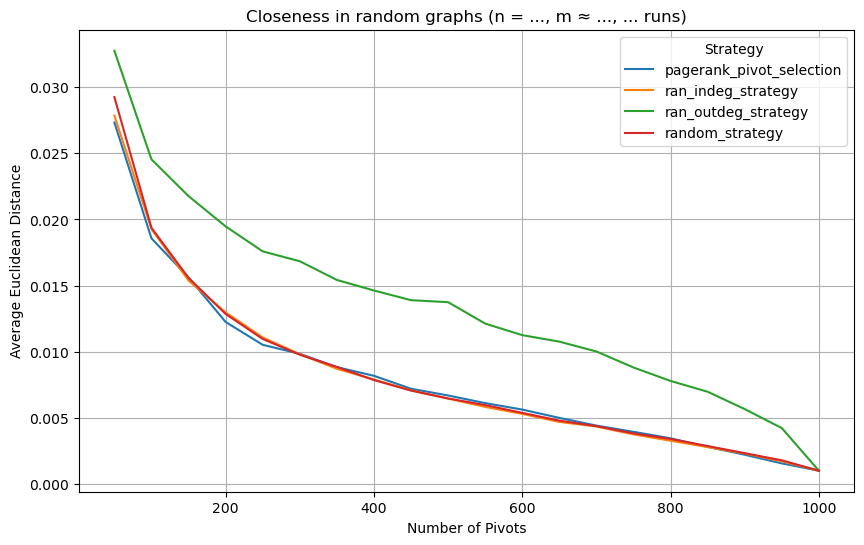

In [16]:
import matplotlib.pyplot as plt

all_results_closeness = pd.concat([results_random, results_pagerank, results_ran_indeg, results_ran_outdeg], ignore_index=True)

# Group by strategy and number of pivots to calculate the mean Euclidean distance
grouped = all_results_closeness.groupby(["strategy", "num_pivots"])["euclidean_distance"].mean().unstack("strategy")

# Plot the results
grouped.plot(figsize=(10, 6))
plt.xlabel("Number of Pivots")
plt.ylabel("Average Euclidean Distance")
plt.title("Closeness in random graphs (n = ..., m ≈ ..., ... runs)")
plt.legend(title="Strategy")
plt.grid(True)
plt.show()

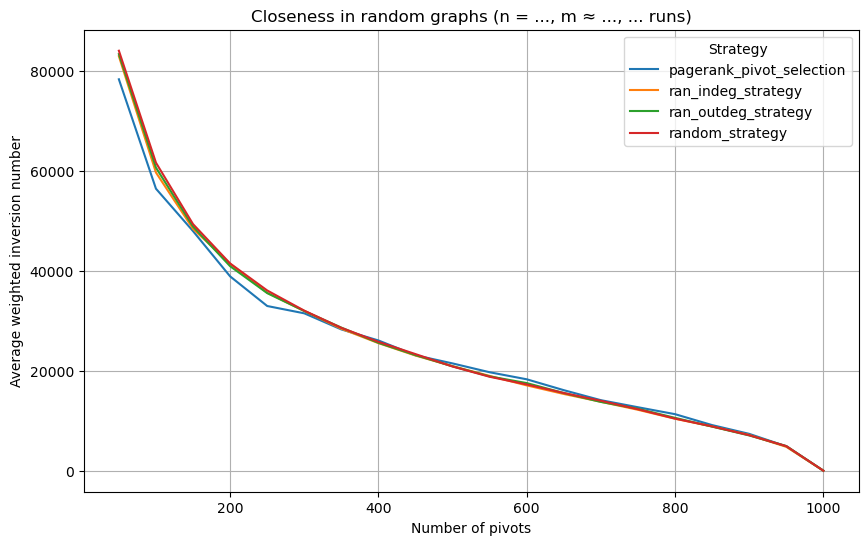

In [17]:
all_results_closeness["inversion_distance"] = all_results_closeness["estimated_closeness"].apply(
    lambda est_closeness: compute_inversion_distance(exact_closeness, est_closeness)
)
all_results_closeness["inversion_distance"].head()

# Group by `num_pivots` and `strategy` to compute the average inversion distance
avg_inversion = all_results_closeness.groupby(["num_pivots", "strategy"])["inversion_distance"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))

# Plot each strategy
for strategy in avg_inversion["strategy"].unique():
    strategy_data = avg_inversion[avg_inversion["strategy"] == strategy]
    plt.plot(
        strategy_data["num_pivots"],
        strategy_data["inversion_distance"],
        label=strategy
    )

# Add labels, legend, and title
plt.xlabel("Number of pivots")
plt.ylabel("Average weighted inversion number")
plt.title("Closeness in random graphs (n = ..., m ≈ ..., ... runs)")
plt.legend(title="Strategy")
plt.grid(True)
plt.show()

## betweenness centrality

In [47]:
shortest_paths = dict(nx.all_pairs_shortest_path(G))

In [ ]:
def approximate_betweenness(G, pivot_strategy):
    dependencies = {node: 0 for node in G.nodes()}
    num_nodes = G.number_of_nodes()
    num_pivots_list = [int(num_nodes / 20 * i) for i in range(1, 21)]
    results = {}

    for num_pivots in num_pivots_list:
        pivots = pivot_strategy(G, num_pivots)
        
        # Reset dependencies for this set of pivots
        approx_centrality = {node: 0 for node in G.nodes()}

        for pivot in pivots:
            # Use precomputed shortest paths
            shortest_paths_pivot = {target: path for target, path in shortest_paths[pivot].items()}
            
            # Back-propagate dependencies using precomputed shortest paths
            for target in shortest_paths_pivot:
                if target == pivot:
                    continue  # Skip the pivot node itself
                
                path = shortest_paths_pivot[target]
                for i in range(1, len(path) - 1):  # Skip source and target
                    intermediary = path[i]
                    approx_centrality[intermediary] += 1  # Increment dependency score

        # Normalize by the number of pivots
        for node in approx_centrality:
            approx_centrality[node] /= num_pivots

        # Store results for this number of pivots
        results[num_pivots] = approx_centrality

    return results


In [57]:
from tqdm import tqdm
import numpy as np

def evaluate_strategies(G, strategies, exact_betweenness, runs=20):
    """
    Evaluates different pivot strategies by calculating normalized Euclidean distances.
    
    Parameters:
        G: NetworkX graph
        strategies: Dictionary of strategies {name: function}
        exact_betweenness: Exact betweenness centrality for comparison
        runs: Number of times to run each strategy (default=20)
    
    Returns:
        results: Dictionary of average normalized distances for each strategy
    """
    num_nodes = G.number_of_nodes()
    num_pivots_list = [int(num_nodes / 20 * i) for i in range(1, 21)]
    results = {name: {} for name in strategies}

    for name, strategy in strategies.items():
        print(f"Running strategy: {name}")
        for num_pivots in tqdm(num_pivots_list, desc=f"Evaluating {name}"):
            distances = []
            for _ in range(runs):
                approx_results = approximate_betweenness(G, strategy)
                
                # Compute normalized Euclidean distance
                approx_scores = approx_results[num_pivots]
                exact_scores = np.array([exact_betweenness[node] for node in G.nodes()])
                approx_values = np.array([approx_scores[node] for node in G.nodes()])
                
                euclidean_distance = np.linalg.norm(exact_scores - approx_values)
                normalized_distance = euclidean_distance / num_nodes
                
                distances.append(normalized_distance)
            
            # Store the average normalized distance for this number of pivots
            results[name][num_pivots] = np.mean(distances)
    
    return results




In [58]:
strategies = {
    "Random": random_strategy,
    "PageRank": pagerank_pivot_selection,
    "Random In-Degree": ran_indeg_strategy,
    "Random Out-Degree": ran_outdeg_strategy,
}

# Compute exact betweenness centrality
exact_betweenness = nx.betweenness_centrality(G)

# Evaluate strategies
results = evaluate_strategies(G, strategies, exact_betweenness)


Running strategy: Random


Evaluating Random: 100%|██████████| 20/20 [12:37<00:00, 37.87s/it]


Running strategy: PageRank


Evaluating PageRank: 100%|██████████| 20/20 [12:13<00:00, 36.68s/it]


Running strategy: Random In-Degree


Evaluating Random In-Degree: 100%|██████████| 20/20 [12:35<00:00, 37.78s/it]


Running strategy: Random Out-Degree


Evaluating Random Out-Degree: 100%|██████████| 20/20 [12:29<00:00, 37.48s/it]


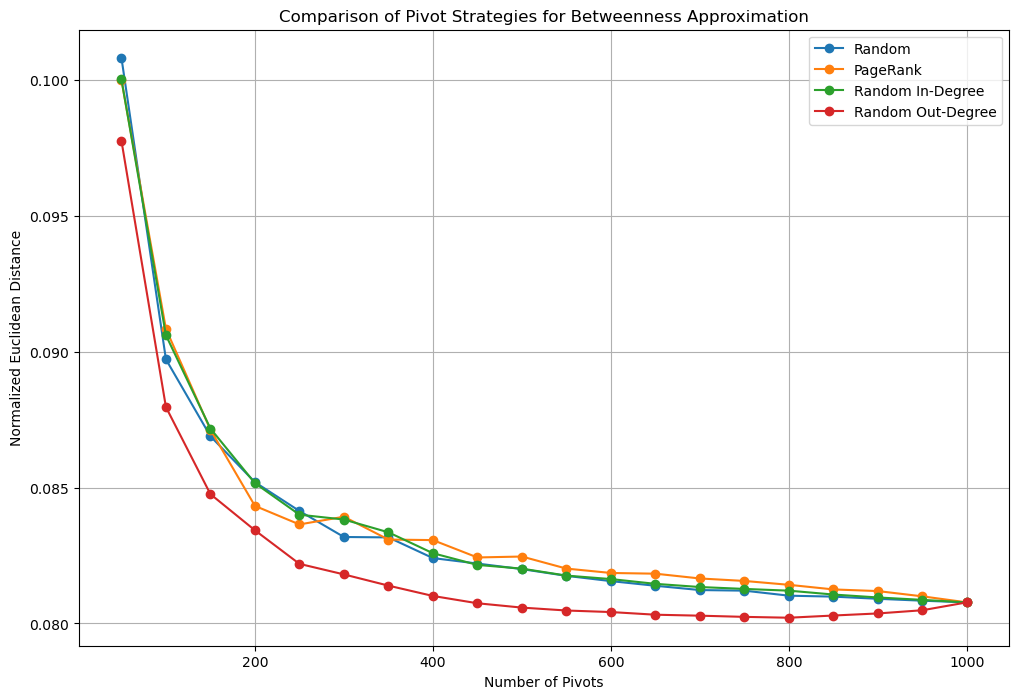

In [59]:
import matplotlib.pyplot as plt

# Plot normalized distances for all strategies
plt.figure(figsize=(12, 8))

for strategy_name, distances in results.items():
    x = list(distances.keys())  # Number of pivots
    y = list(distances.values())  # Normalized Euclidean distances
    plt.plot(x, y, marker='o', label=strategy_name)

plt.xlabel("Number of Pivots")
plt.ylabel("Normalized Euclidean Distance")
plt.title("Comparison of Pivot Strategies for Betweenness Approximation")
plt.legend()
plt.grid()
plt.show()

